In [ ]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
sns.set(context='paper', style='ticks', font='Arial')
import openTSNE
from openTSNE import TSNE
import umap.umap_
from matplotlib.colors import ListedColormap
import phate

print('openTSNE', openTSNE.__version__)

/u/home/a/asarkar/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Common function

In [4]:
# perplexity, number of points, dimensions, noise and initialization

class benchmark:
    def __init__(self, perplexity, npoints, dimension, noise, initial):
        self.perplexity = perplexity
        self.npoints = npoints
        self.dimension = dimension
        self.noise = noise
        self.initial = initial
    
    def gen_data(self):
        
        # randomisation once
        np.random.seed(42)
        X = np.random.randn(self.npoints,self.dimension) / 1000
        
        X[:,0] += np.cos(np.arange(self.npoints)*2*np.pi/self.npoints)
        X[:,1] += np.sin(np.arange(self.npoints)*2*np.pi/self.npoints)
        
        return X
    
    def TSNE_test(self):
        X = self.gen_data()
        Z1 = TSNE(n_jobs=-1, initialization=self.initial, random_state=42, negative_gradient_method='bh').fit(X)
        Z2 = TSNE(n_jobs=-1, negative_gradient_method='bh').fit(X)
        return Z1,Z2
    
    def UMAP_test(self):
        X = self.gen_data()
        Z3 = umap.UMAP(init='random', random_state=42).fit_transform(X)
        Z4 = umap.UMAP().fit_transform(X)
        return Z3,Z4

    def plot_test(self):
        cmap = ListedColormap(sns.husl_palette(self.npoints))

        titles = ['Data', 't-SNE, random init', 't-SNE, PCA init', 
                  'UMAP, random init', 'UMAP, LE init']

        plt.figure(figsize=(8,2))
        
        # initialization
        X = self.gen_data()
        Z1,Z2 = self.TSNE_test()
        Z3,Z4 = self.UMAP_test()
        
        print(Z1.shape)
        print(Z2.shape)

        for i,Z in enumerate([X,Z1,Z2,Z3,Z4],1):
            plt.subplot(1,5,i)
            plt.gca().set_aspect('equal', adjustable='datalim')
            plt.scatter(Z[:,0], Z[:,1], s=1, c=np.arange(self.npoints), cmap=cmap, 
                        edgecolor='none', rasterized=True)
            plt.xticks([])
            plt.yticks([])
            plt.title(titles[i-1], fontsize=8)
        plt.show()
            
        sns.despine(left=True, bottom=True)
        plt.tight_layout()

### 3D sphere

##############################
3D STD


<IPython.core.display.Javascript object>


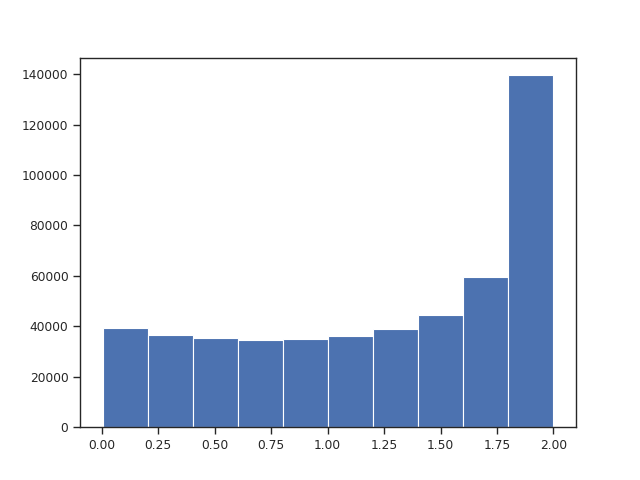

<IPython.core.display.Javascript object>


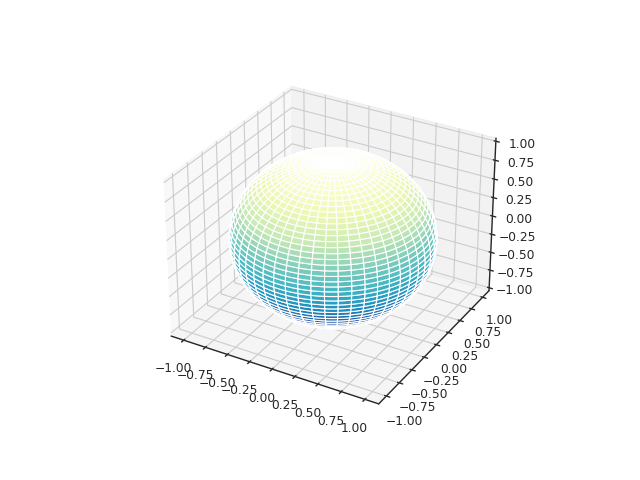

<IPython.core.display.Javascript object>


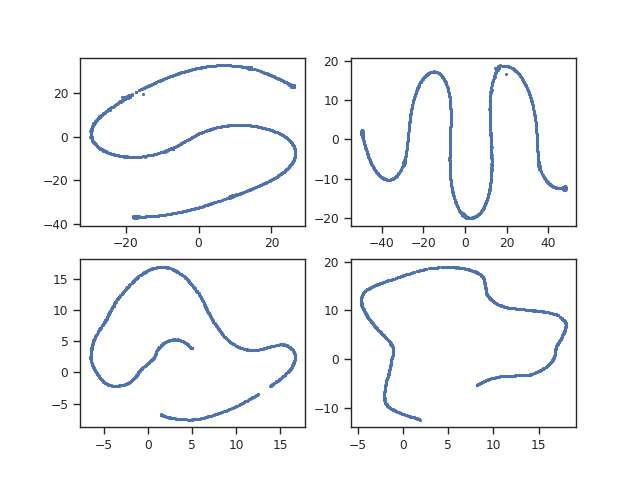

<IPython.core.display.Javascript object>


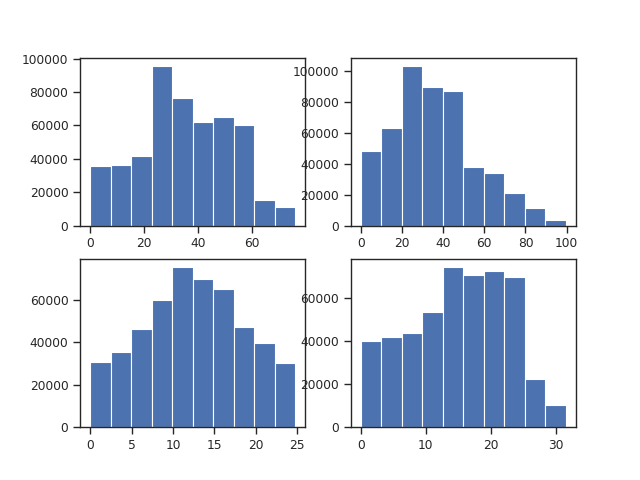

##############################
STD for  TSNE Random =  17.069528275955648
##############################
STD for  TSNE PCA =  20.19146660323291
##############################
STD for  UMAP Random =  6.107016461098368
##############################
STD for  UMAP PCA =  7.491104681033592
##############################
Value of mean distance is 
TSNE Random 0.47230600102708353
TSNE PCA 0.35927032977199785
UMAP Random 0.493553350975245
UMAP PCA 0.4822729317854541


In [17]:
import numpy as np
import random
from scipy.spatial.distance import cdist

class benchmark_sphere(benchmark):
    def __init__(self, perplexity, npoints, dimension, noise, initial, radius, center):
        super().__init__(perplexity, npoints, dimension, noise, initial)
        self.radius = radius
        self.center = center
        
    def gen_sphere(self):
        phi = np.linspace(0, 2*np.pi, self.npoints)
        theta = np.linspace(0, np.pi, self.npoints)
        
        cx,cy,cz = self.center
        
        theta1, phi1 = np.meshgrid(theta, phi)
        
        r_xy = self.radius*np.sin(theta)
        x = cx + np.cos(phi) * r_xy
        y = cy + np.sin(phi) * r_xy
        z = cz + self.radius * np.cos(theta)
        
        self.mean_dist3d(x,y,z)
        
        X = np.stack([x,y,z])
        
        r_xy = self.radius*np.sin(theta1)
        x = cx + np.cos(phi1) * r_xy
        y = cy + np.sin(phi1) * r_xy
        z = cz + self.radius * np.cos(theta1)
        
        X1 = np.stack([x,y,z])
        
        self.plot_sphere(X1)
        return X
    
    def plot_sphere(self,X):
        fig = plt.figure()
        x,y,z = X
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
        plt.show()
    
    def dim_red(self, typ):
        X = self.gen_sphere()
        X = X.reshape((X.shape[-1], 3))
        Z1 = TSNE(n_jobs=-1, initialization=self.initial, random_state=0, negative_gradient_method='bh').fit(X)
        Z2 = TSNE(n_jobs=-1, negative_gradient_method='bh', random_state=20).fit(X)
        Z3 = umap.UMAP(init='random', random_state=42).fit_transform(X)
        Z4 = umap.UMAP().fit_transform(X)
        return(Z1, Z2, Z3, Z4)   

    def upper_tri_masking(self,A):
        m = A.shape[0]
        r = np.arange(m)
        mask = r[:,None] < r
        return A[mask]
    
    def mean_dist3d(self,x,y,z):
        s=[]
        for i in range(1000):
            r1 = random.sample(range(0,x.shape[0]), 2)
            u = np.array([x[r1[0]],y[r1[0]],z[r1[0]]])
            v = np.array([x[r1[1]],y[r1[1]],z[r1[1]]])
            d = np.linalg.norm(u-v)
            s.append(d)

        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        z = z.reshape(-1,1)
        X = np.concatenate((x, y, z), axis=1)
        dmax = np.amax(cdist(X,X))
        std = np.std(self.upper_tri_masking(cdist(X,X)))
        
        print('#'*30)
        print("3D STD")
        plt.figure()
        plt.hist(self.upper_tri_masking(cdist(X,X)))
        plt.show()

    def mean_dist(self,x,y,u,name):
        s=[]
        f,g = u
        for i in range(self.npoints):
            r1 = random.sample(range(0,x.shape[0]), 2)
            u = np.array([x[r1[0]],y[r1[0]]])
            v = np.array([x[r1[1]],y[r1[1]]])
            d = np.linalg.norm(u-v)
            s.append(d)

        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        X = np.concatenate((x, y), axis=1)
        dmax = np.amax(cdist(X,X))
        std = np.std(self.upper_tri_masking(cdist(X,X)))

        ax[f,g].hist(self.upper_tri_masking(cdist(X,X)))
        
        dmean = sum(s)/len(s)
        dmean_norm = dmean/dmax
        print('#'*30)
        print("STD for ",name, "= ", std)
        return(dmean_norm)

s = benchmark_sphere(100,1000,3,3,'random', 1, (0,0,0))
Z1,Z2,Z3,Z4 = s.dim_red("ALL")

x1,y1 = Z1.T
x2,y2 = Z2.T
x3,y3 = Z3.T
x4,y4 = Z4.T

fig, ax = plt.subplots(2,2)

ax[0,0].scatter(x1,y1,s=2)
ax[0,1].scatter(x2,y2,s=2)
ax[1,0].scatter(x3,y3,s=2)
ax[1,1].scatter(x4,y4,s=2)

plt.show()

fig, ax = plt.subplots(2,2)

m1 = s.mean_dist(x1,y1,[0,0],"TSNE Random")
m2 = s.mean_dist(x2,y2,[0,1],"TSNE PCA")
m3 = s.mean_dist(x3,y3,[1,0],"UMAP Random")
m4 = s.mean_dist(x4,y4,[1,1],"UMAP PCA")

plt.show()

print('#'*30)
print("Value of mean distance is ")
print("TSNE Random", m1)
print("TSNE PCA", m2)
print("UMAP Random", m3)
print("UMAP PCA", m4)

<IPython.core.display.Javascript object>


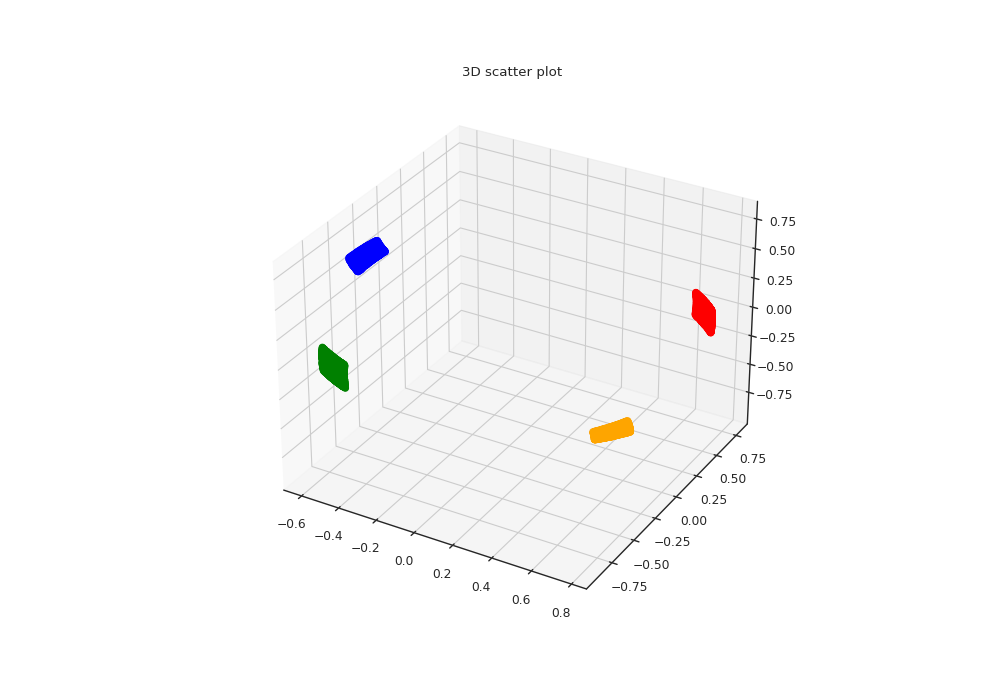

##############################
3D STD


<IPython.core.display.Javascript object>


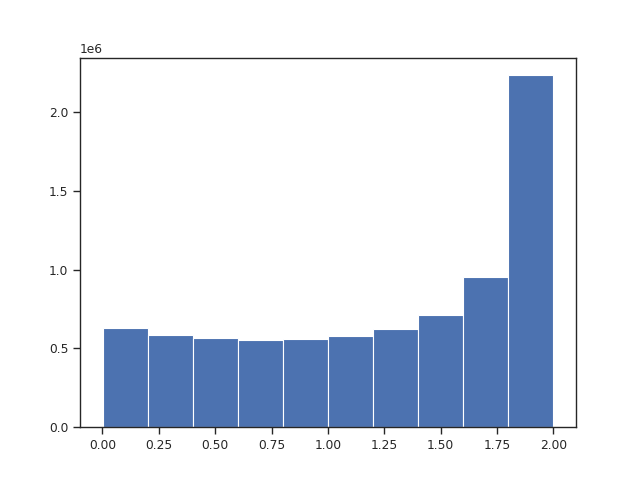

<IPython.core.display.Javascript object>


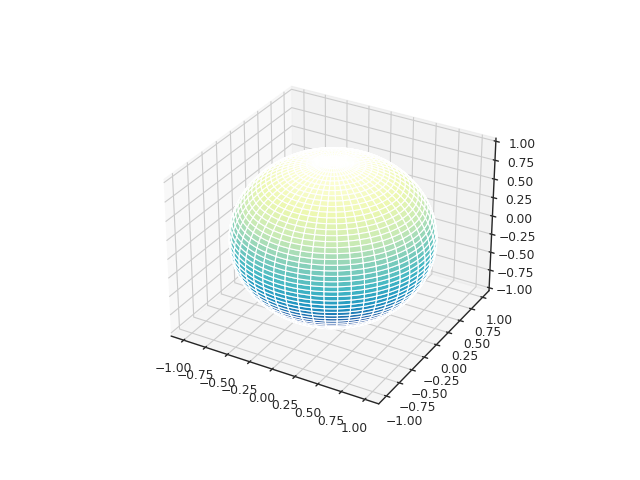

<IPython.core.display.Javascript object>


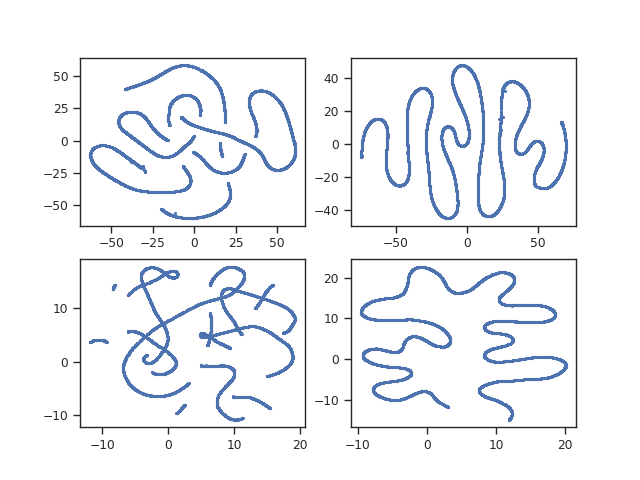

<IPython.core.display.Javascript object>


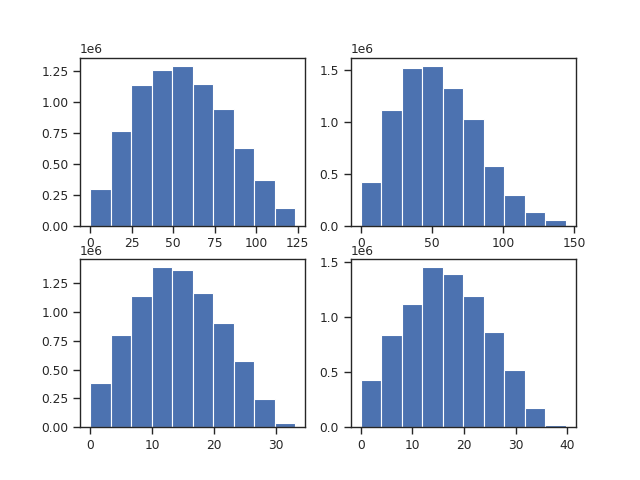

##############################
STD for  TSNE Random =  26.661532880656555
##############################
STD for  TSNE PCA =  27.747285796266546
##############################
STD for  UMAP Random =  6.748812144324164
##############################
STD for  UMAP PCA =  7.911986881284819
##############################
Value of mean distance is 
TSNE Random 0.4487370265286322
TSNE PCA 0.38043937832313873
UMAP Random 0.4305185668073093
UMAP PCA 0.4149213014529053


In [19]:
from mpl_toolkits import mplot3d

class benchmark_clusters(benchmark_sphere):
    def __init__(self, perplexity, npoints, dimension, noise, initial, radius, center):
        benchmark_sphere.__init__(self, perplexity, npoints, dimension, noise, initial,radius, center)
        
        
    def gen_points(self, phi, theta):
        
        cx,cy,cz = self.center
        
        p=[]
        t=[]
        
        for i in range(self.npoints):
            px = random.sample(range(0,self.npoints), 1)[0]
            tx = random.sample(range(0,self.npoints), 1)[0]
            p.append(phi[px])
            t.append(theta[tx])

        p = np.asarray(p)
        t = np.asarray(t)
        
        r_xy = self.radius * np.sin(t)
        x = cx + np.cos(p) * r_xy
        y = cy + np.sin(p) * r_xy
        z = cz + self.radius * np.cos(t)
        
        X = np.stack([x,y,z])
        
        return(X)

    def plot_clusters(self, phi1, theta1, phi2, theta2, phi3, theta3, phi4, theta4):
        
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        
        x1,y1,z1 = self.gen_points(phi1, theta1)
        x2,y2,z2 = self.gen_points(phi2, theta2)
        x3,y3,z3 = self.gen_points(phi3, theta3)
        x4,y4,z4 = self.gen_points(phi4, theta4)
        
        ax.scatter3D(x1, y1, z1, color = "red")
        ax.scatter3D(x2, y2, z2, color = "blue")
        ax.scatter3D(x3, y3, z3, color = "green")
        ax.scatter3D(x4, y4, z4, color = "orange")
        
        plt.title("3D scatter plot")
        plt.show
    
    def gen_clusters(self):
        cpoints = self.npoints//4
        
        pc = [np.pi/4, (5*np.pi)/4, np.pi/3, np.pi/6]
        tc = [np.pi/2, np.pi/4, (3*np.pi)/2, (5*np.pi)/6]
        
        cx,cy,cz = self.center
        
        phi=[]
        theta=[]
        
        for i in range(4):
            phi.append(np.linspace(pc[i]-0.1, pc[i]+0.1, self.npoints))
            theta.append(np.linspace(tc[i]-0.1, tc[i]+0.1, self.npoints))
        
        self.plot_clusters(phi[0], theta[0], phi[1], theta[1], phi[2], theta[2], phi[3], theta[3])
        
        phi = np.concatenate((phi[0], phi[1], phi[2], phi[3]), axis=0)
        theta = np.concatenate((theta[0], theta[1], theta[2], theta[3]), axis=0)
        
        return(phi,theta)

s = benchmark_clusters(100,4000,3,3,'random', 1, (0,0,0))
phi,theta = s.gen_clusters()

Z1,Z2,Z3,Z4 = s.dim_red("ALL")

x1,y1 = Z1.T
x2,y2 = Z2.T
x3,y3 = Z3.T
x4,y4 = Z4.T

fig, ax = plt.subplots(2,2)

ax[0,0].scatter(x1,y1,s=2)
ax[0,1].scatter(x2,y2,s=2)
ax[1,0].scatter(x3,y3,s=2)
ax[1,1].scatter(x4,y4,s=2)

plt.show()

fig, ax = plt.subplots(2,2)

m1 = s.mean_dist(x1,y1,[0,0],"TSNE Random")
m2 = s.mean_dist(x2,y2,[0,1],"TSNE PCA")
m3 = s.mean_dist(x3,y3,[1,0],"UMAP Random")
m4 = s.mean_dist(x4,y4,[1,1],"UMAP PCA")

plt.show()

print('#'*30)
print("Value of mean distance is ")
print("TSNE Random", m1)
print("TSNE PCA", m2)
print("UMAP Random", m3)
print("UMAP PCA", m4)

<IPython.core.display.Javascript object>


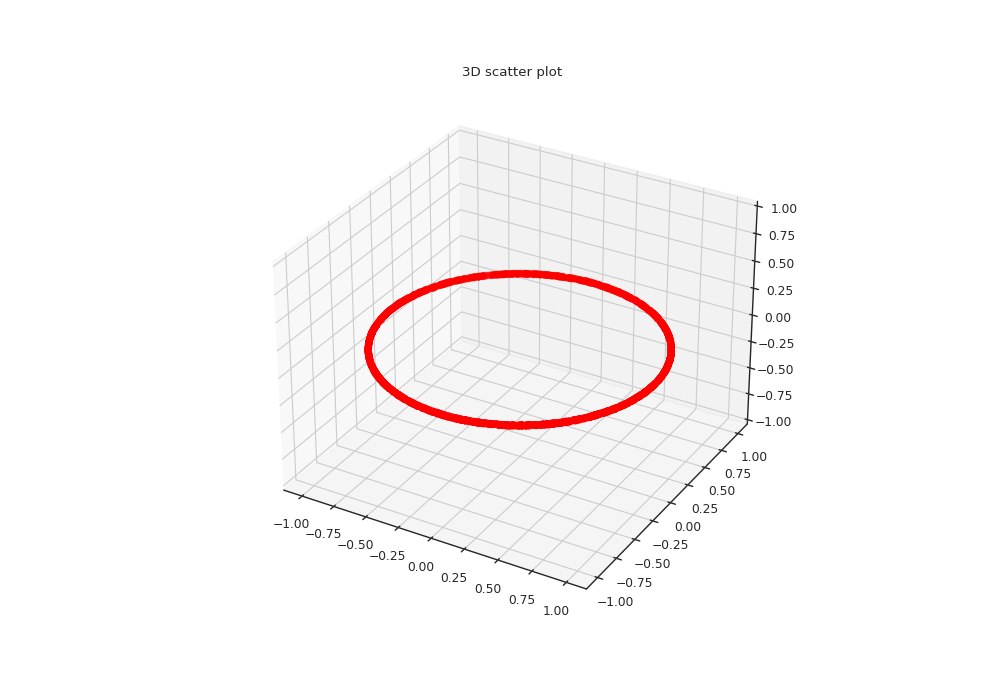

##############################
3D STD


<IPython.core.display.Javascript object>


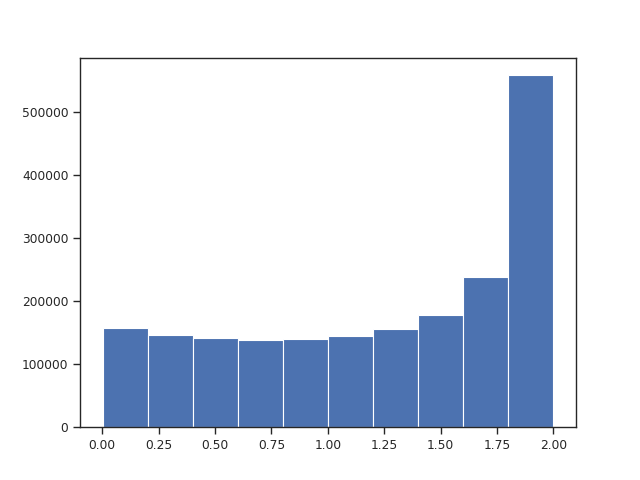

<IPython.core.display.Javascript object>


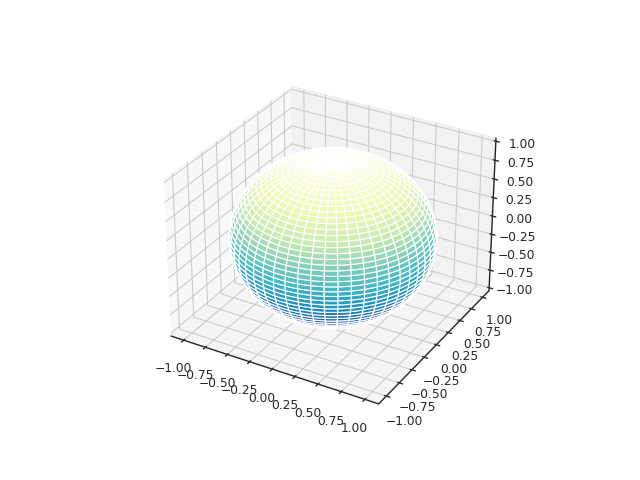

<IPython.core.display.Javascript object>


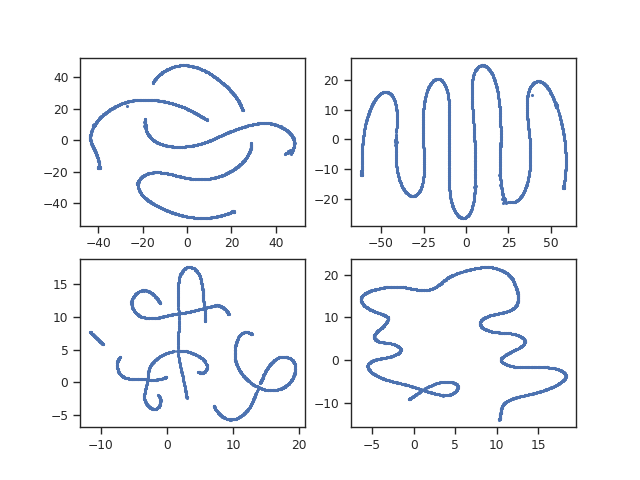

<IPython.core.display.Javascript object>


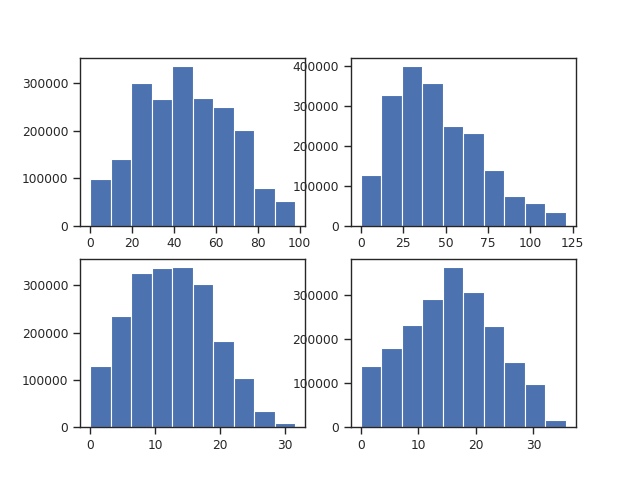

##############################
STD for  TSNE Random =  21.746738846671477
##############################
STD for  TSNE PCA =  25.63971696898562
##############################
STD for  UMAP Random =  6.2823533559641325
##############################
STD for  UMAP PCA =  7.739888720031832
##############################
Value of mean distance is 
TSNE Random 0.4667279674699775
TSNE PCA 0.3733213855972674
UMAP Random 0.40046203378527506
UMAP PCA 0.4327247882745781


In [22]:
class benchmark_ring(benchmark_clusters):
    def __init__(self, perplexity, npoints, dimension, noise, initial, radius, center, epsilon):
        benchmark_clusters.__init__(self, perplexity, npoints, dimension, noise, initial,radius, center)
        self.epsilon = epsilon
         
    def create_ring(self):
#         width = np.abs(np.random.normal(0, self.epsilon, 1)[0])
        width = np.abs(0.01)
        theta = np.pi/2
        phi = np.linspace(0, 2*np.pi, num=self.npoints)
        dtheta = np.abs(np.arcsin(width/(2*self.radius)))
        theta = np.linspace(theta-dtheta, theta+dtheta, num=self.npoints)
        self.plot_ring(phi, theta)
        return(phi, theta)
    
    def plot_ring(self, phi, theta):
        cx,cy,cz = self.center
        
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        
        x,y,z = self.gen_points(phi, theta)
        
        ax.scatter3D(x, y, z, color = "red")
        ax.set_zticks(np.linspace(-self.radius,self.radius,num=9))
        
        plt.title("3D scatter plot")
        plt.show     

s = benchmark_ring(100,2000,3,3,'random', 1, (0,0,0),1)
phi,theta = s.create_ring()

Z1,Z2,Z3,Z4 = s.dim_red("ALL")

x1,y1 = Z1.T
x2,y2 = Z2.T
x3,y3 = Z3.T
x4,y4 = Z4.T

fig, ax = plt.subplots(2,2)

ax[0,0].scatter(x1,y1,s=2)
ax[0,1].scatter(x2,y2,s=2)
ax[1,0].scatter(x3,y3,s=2)
ax[1,1].scatter(x4,y4,s=2)

plt.show()

fig, ax = plt.subplots(2,2)

m1 = s.mean_dist(x1,y1,[0,0],"TSNE Random")
m2 = s.mean_dist(x2,y2,[0,1],"TSNE PCA")
m3 = s.mean_dist(x3,y3,[1,0],"UMAP Random")
m4 = s.mean_dist(x4,y4,[1,1],"UMAP PCA")

plt.show()

print('#'*30)
print("Value of mean distance is ")
print("TSNE Random", m1)
print("TSNE PCA", m2)
print("UMAP Random", m3)
print("UMAP PCA", m4)

### N-D hypersphere

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
import random
from scipy.spatial.distance import cdist
import pandas as pd
import phate
import datetime

class benchmark_hypersphere(benchmark):
    def __init__(self, perplexity, npoints, dimension, noise, initial, radius):
        super().__init__(perplexity, npoints, dimension, noise, initial)
        self.radius = radius
        
    def gen_hypersphere(self):
        N = self.npoints
        dim = self.dimension

        norm = np.random.normal
        normal_deviates = norm(size=(dim, N))

        rad = np.sqrt((normal_deviates**2).sum(axis=0))
        points = normal_deviates/rad * self.radius
        print(type(points))
        return points
    
    def upper_tri_masking(self,A):
        m = A.shape[0]
        r = np.arange(m)
        mask = r[:,None] < r
        return A[mask]
    
    def dim_red(self, typ, nratio):
        X = self.gen_hypersphere()
        X = X.reshape((X.shape[-1], self.dimension))
        
        rownames = np.asarray(random.sample(range(0, X.shape[0]), int(nratio*self.npoints)))
        print(X[rownames].shape)
        print(np.random.normal(0,1,(int(nratio*self.npoints),self.dimension)).shape)
        X[rownames] = X[rownames] + np.random.normal(0,1,(int(nratio*self.npoints),self.dimension))
        
        early = datetime.datetime.now()
        Z1 = TSNE(n_jobs=-1, initialization=self.initial, random_state=0, negative_gradient_method='bh').fit(X)
        now = datetime.datetime.now()
        print("Time for TSNE 1 = ", str(now-early))
        
        early = datetime.datetime.now()
        Z2 = TSNE(n_jobs=-1, negative_gradient_method='bh', random_state=20).fit(X)
        now = datetime.datetime.now()
        print("Time for TSNE 2 = ", str(now-early))
        
        early = datetime.datetime.now()
        Z3 = umap.UMAP(init='random', random_state=42).fit_transform(X)
        now = datetime.datetime.now()
        print("Time for UMAP 1 = ", str(now-early))
        
        early = datetime.datetime.now()
        Z4 = umap.UMAP().fit_transform(X)
        now = datetime.datetime.now()
        print("Time for UMAP 2 = ", str(now-early))
        
        early = datetime.datetime.now()
        Z5 = phate.PHATE(n_components=2).fit_transform(X)
        now = datetime.datetime.now()
        print("Time for PHATE = ", str(now-early))
        
        print(Z5.shape)
        return(X, Z1, Z2, Z3, Z4, Z5)
    
    def color_code(self, X, Ncolors):
        d=[]
        index=np.asarray(range(X.shape[0]))
        t = X[random.sample(range(0,X.shape[0]), 1)[0]]
        for i in range(X.shape[0]):
            dist = np.linalg.norm(t-X[i])
            d.append(dist)
        rang = max(d) - min(d)
        
        bins = np.arange(min(d),max(d)+rang/Ncolors,rang/Ncolors)
        d = np.asarray(d)
        col=[]
        for i in range(1, bins.shape[0]):
            col.append(index[np.digitize(d,bins)==i])
        return(col, bins)
    
    def custom_scatter(self,X,col,bins,k):
        a,b = k
        l = 0
        for i in col:
            x,y = X[i].T
            ax[a,b].scatter(x,y,s=50,label=str(round(bins[l],3))+"-"+str(round(bins[l+1],3)),marker='x')
            l = l+1
        ax[a,b].legend(loc="upper left",prop={'size': 6})
    
    def mean_distnd(self, Z, typ, k):
        s=[]
        
        a,b = k
        
        Z = np.asarray(Z)
        for i in range(Z.shape[0]):
            r1 = random.sample(range(0,Z.shape[0]), 2)
            u = Z[r1[0]]
            v = Z[r1[1]]
            d = cityblock(u,v)
            s.append(d)

        if typ == "reduced":
            Z = Z.reshape((Z.shape[0],2))
        else:
            Z = Z.reshape((Z.shape[0],self.dimension))
            
        t = cdist(Z,Z, metric="euclidean")
        dmax = np.amax(t)
        print("SHAPE",t.shape)
        std = np.std(self.upper_tri_masking(t))
        ax[a,b].hist(self.upper_tri_masking(t))
        return(sum(s)/len(s), std)
        
# # perplexity, npoints, dimension, noise, initial, radius, center
# S = benchmark_hypersphere(100,1000,10000,3,'random', 1)
# X,Z1,Z2,Z3,Z4,Z5 = S.dim_red("ALL",0.8)

# print('#'*30)
# print("N-D HISTOGRAM")
# fig, ax = plt.subplots(3,2)

# m1, std1 = S.mean_distnd(Z1,"reduced", [0,0])
# m2, std2 = S.mean_distnd(Z2,"reduced", [0,1])
# m3, std3 = S.mean_distnd(Z3,"reduced", [1,0])
# m4, std4 = S.mean_distnd(Z4,"reduced", [1,1])
# m6, std6 = S.mean_distnd(Z5,"reduced", [2,1])
# m5, std5 = S.mean_distnd(X,"full", [2,0])

# plt.show()


# print('#'*30)
# print("2D SCATTER")

# fig, ax = plt.subplots(3,2,figsize=(8, 8))

# col, bins = S.color_code(Z1,5)
# S.custom_scatter(Z1,col,bins,[0,0])

# col, bins = S.color_code(Z2,5)
# S.custom_scatter(Z2,col,bins,[0,1])

# col, bins = S.color_code(Z3,5)
# S.custom_scatter(Z3,col,bins,[1,0])

# col, bins = S.color_code(Z4,5)
# S.custom_scatter(Z4,col,bins,[1,1])

# col, bins = S.color_code(Z5,5)
# S.custom_scatter(Z4,col,bins,[2,0])

# plt.show()

# print('#'*30)
# print("Value of mean distance is ")
# print("TSNE Random", m1)
# print("TSNE PCA", m2)
# print("UMAP Random", m3)
# print("UMAP PCA", m4)
# print("Phate", m6)
# print("Original points", m5)

### New methods

In [7]:
# 5 techniques - Kmeans, GMM, DBSCan, SpectralC, Optics
from sklearn.cluster import KMeans,OPTICS,SpectralClustering,DBSCAN
from sklearn.mixture import GaussianMixture

class new_method(benchmark_hypersphere):
    def __init__(self, perplexity, npoints, dimension, noise, initial, radius, k):
        super().__init__(perplexity, npoints, dimension, noise, initial,radius)
        self.k = k
        
    def generate_hypersphere(self):
        N = self.npoints
        dim = self.dimension

        norm = np.random.normal
        normal_deviates = norm(size=(dim, N))

        rad = np.sqrt((normal_deviates**2).sum(axis=0))
        points = normal_deviates/rad * self.radius
        return points.T
        
    def generate_gaussian(self):
        N = self.npoints
        dim = self.dimension
        mean1 = np.ones(self.dimension)
        mean2 = 5*np.ones(self.dimension)
        
        cov = np.identity(self.dimension)

        points1 = np.random.multivariate_normal(mean1, cov, self.npoints)
        points2 = np.random.multivariate_normal(mean2, cov, self.npoints)
        points = np.concatenate((points1,points2),axis=0)
        return points
    
    def clustering(self):
        p1 = self.generate_gaussian()
        centers = KMeans(n_clusters=self.k, random_state=42).fit(p1).cluster_centers_
        return centers
        
    def dimred_vis(self):
        X = self.clustering()
        Z1 = TSNE(n_jobs=-1, initialization=self.initial, random_state=42, negative_gradient_method='bh').fit(X)
        Z2 = TSNE(n_jobs=-1, negative_gradient_method='bh').fit(X)
#         Z3 = umap.UMAP(init='random', random_state=42).fit_transform(X)
#         Z4 = umap.UMAP().fit_transform(X)
        return Z1,Z2,Z3,Z4

# perplexity, npoints, dimension, noise, initial, radius, k
S = new_method(100,1000,3,100,'random', 1,10)
Z1,Z2,Z3,Z4 = S.dimred_vis()

print('#'*30)
print("N-D HISTOGRAM")
fig, ax = plt.subplots(2,2)

m1, std1 = S.mean_distnd(Z1,"reduced", [0,0])
m2, std2 = S.mean_distnd(Z2,"reduced", [0,1])
m3, std3 = S.mean_distnd(Z3,"reduced", [1,0])
m4, std4 = S.mean_distnd(Z4,"reduced", [1,1])

plt.show()


print('#'*30)
print("2D SCATTER")

fig, ax = plt.subplots(2,2,figsize=(8, 8))

col, bins = S.color_code(Z1,5)
S.custom_scatter(Z1,col,bins,[0,0])

col, bins = S.color_code(Z2,5)
S.custom_scatter(Z2,col,bins,[0,1])

col, bins = S.color_code(Z3,5)
S.custom_scatter(Z3,col,bins,[1,0])

col, bins = S.color_code(Z4,5)
S.custom_scatter(Z4,col,bins,[1,1])

plt.show()

Perplexity value 30 is too high. Using perplexity 3.00 instead
Perplexity value 30 is too high. Using perplexity 3.00 instead


AttributeError: module 'umap' has no attribute 'UMAP'

In [10]:
!pip install umap-learn==0.4.6

Defaulting to user installation because normal site-packages is not writeable
  Using cached umap-learn-0.4.6.tar.gz (69 kB)
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67948 sha256=8e69e712cefce218051dd3ef210bf84ac5b8e2930a3535fad206e4390e9b6e76
  Stored in directory: /u/home/a/asarkar/.cache/pip/wheels/d2/02/7d/e86ab91f3eb78138fb1fad33efb96c7fac61f1b75369817210
Successfully built umap-learn
You should consider upgrading via the '/u/local/apps/python/3.9.6/gcc-4.8.5/bin/python3.9 -m pip install --upgrade pip' command.


In [13]:
import umap
fit = umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'

### Rough

In [4]:
import numpy as np

mean = np.ones(5)
cov = np.identity(5)
a1=np.random.multivariate_normal(mean, cov, 5000)
a2=np.random.multivariate_normal(mean, cov, 5000)
np.concatenate((a1,a2),axis=0).shape

(10000, 5)

In [10]:
dim = 9
N = 100

norm = np.random.normal
Z = norm(size=(dim, N))
Z = Z.reshape((N,dim))

phate.PHATE(n_components=2).fit_transform(Z).shape

Calculating PHATE...
  Running PHATE on 100 observations and 9 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.08 seconds.


(100, 2)

In [58]:
import numpy as np
mylist = np.array([-0.234, -0.04325, -0.43134, -0.315, -0.6322, -0.245,
                       -0.5325, -0.6341, -0.5214, -0.531, -0.124, -0.0252, -0.9, -0.99])
mylist[np.array([1,2,3,4,5])]

array([-0.04325, -0.43134, -0.315  , -0.6322 , -0.245  ])

In [33]:
np.random.normal(0, 1, 1)[0]

1.4730909231447322

<IPython.core.display.Javascript object>


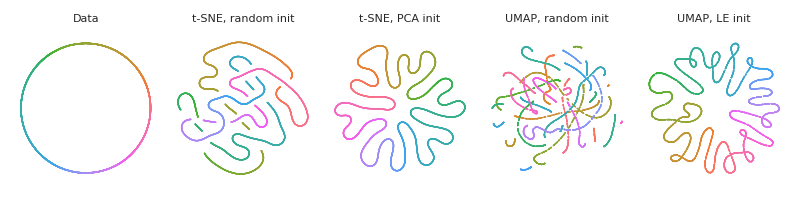

(7000, 3)
(7000, 3)
(7000, 3)
(7000, 2)
(7000, 2)


In [33]:
obj = benchmark(100,7000,2,3,'random')
obj.plot_test()

In [4]:
import numpy as np
from scipy.spatial.distance import cdist

X = np.arange(10).reshape(-1,2)
Y = np.arange(10).reshape(-1,2)

cdist(X,X)

array([[ 0.        ,  2.82842712,  5.65685425,  8.48528137, 11.3137085 ],
       [ 2.82842712,  0.        ,  2.82842712,  5.65685425,  8.48528137],
       [ 5.65685425,  2.82842712,  0.        ,  2.82842712,  5.65685425],
       [ 8.48528137,  5.65685425,  2.82842712,  0.        ,  2.82842712],
       [11.3137085 ,  8.48528137,  5.65685425,  2.82842712,  0.        ]])